# **DESAFIO 3 G2** 
# **Dataset Imagenes Covid-19 - Modelo de clasificacion supervisado.**
---

<a id="section_toc"></a> 
## Tabla de Contenidos

[Intro](#section_toc)

Armado y presentacion de dataset

$\hspace{.5cm}$[Importaciones y carga de bibliotecas](#sec_imp)

$\hspace{.5cm}$[Alcance del trabajo y caracteristicas generales](#sec_alcance)

$\hspace{.5cm}$[Analisis previos y observacion de variables](#sec_apo)

$\hspace{.9cm}$[Inspeccion de variables](#sec_apo_ds)

$\hspace{.9cm}$[Caracteristicas generales del dataset](#sec_apo_nc)

Implementacion de modelos de clasificacion supervisados

$\hspace{.5cm}$[Armado de set de entrenamiento y testing](#sec_set)
  
$\hspace{.5cm}$[KNeighborsClassifier](#sec_knn)

$\hspace{.9cm}$[Analisis](#sec_knn_a)

$\hspace{.9cm}$[Optimizacion de hiperparametros mediante GridSearchCV](#sec_knn_gs)

$\hspace{.9cm}$[Metricas y evaluacion del modelo](#sec_knn_eval)

$\hspace{.5cm}$[Gaussian Naive Bayes](#sec_gnb)

$\hspace{.9cm}$[Analisis](#sec_gnb_a)

$\hspace{.9cm}$[Metricas y evaluacion del modelo](#sec_gnb_eval)

$\hspace{.5cm}$[Logistic Regression](#sec_lr)

$\hspace{.9cm}$[Analisis](#sec_lr_a)

$\hspace{.9cm}$[Optimizacion de hiperparametros mediante GridSearchCV](#sec_lr_gs)

$\hspace{.9cm}$[Metricas y evaluacion del modelo](#sec_lr_eval)

Conclusiones

$\hspace{.5cm}$[Conclusiones](#sec_conclusiones)

---

## Armado y presentacion de dataset

<a id="sec_imp"></a> 
### Importaciones y carga de bibliotecas

[volver a TOC](#section_toc)

In [1]:
!pip install opencv-python

#### Importacion de bibliotecas generales

In [2]:
import os
import sys
import re

In [3]:
import pandas as pd
import numpy as np

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

In [5]:
import cv2
import skimage
import skimage.io
import skimage.transform

In [6]:
import pickle

#### Importacion de librerias para armado y testeo de modelos

In [7]:
# operaciones sobre variables
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report, f1_score, accuracy_score, precision_score, make_scorer
from sklearn.pipeline import Pipeline, make_pipeline, make_union

# modelos de clasificacion
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.ensemble import GradientBoostingClassifier

# normalizacion de variables
from sklearn.preprocessing import StandardScaler, OneHotEncoder, RobustScaler

# feature selection
from sklearn.feature_selection import SelectKBest, f_classif, f_regression

# Analisis de dimensiones
from sklearn.decomposition import PCA
from sklearn.manifold import Isomap
from sklearn.manifold import TSNE

#### Importacion de modelos de clasificacion entrenados

In [8]:
# Modelo Regresion Logistica
with open('../modelos/model_lr.pkl', 'rb') as lr_model:
        model_logreg = pickle.load(lr_model)

# Modelo Gaussian Naive Bayes
# with open('../modelos/model_gnb.pkl', 'rb') as gnb_model:
#         model_gnb = pickle.load(gnb_model)

# # Modelo Regresion Logistica con ajuste de parametros e hiperparametros via Grid Search con Cross Validation
# with open('../modelos/model_lr_gs.pkl', 'rb') as lr_gs_model:
#         model_logreg_gs = pickle.load(lr_gs_model)

# # Modelo KNeighborsClassifier
# with open('../modelos/model_knn.pkl', 'rb') as knn_model:
#         model_knn = pickle.load(knn_model)

# # Modelo Regresion Logistica con ajuste de parametros e hiperparametros via Grid Search con Cross Validation
# with open('../modelos/model_knn_gs.pkl', 'rb') as knn_gs_model:
#         modelo_knn_gs = pickle.load(knn_gs_model)

#### Comprobacion modelos

In [9]:
model_logreg

LogisticRegression(max_iter=1000)

In [10]:
model_gnb

GaussianNB()

In [11]:
model_logreg_gs

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=0, shuffle=True),
             estimator=LogisticRegression(), n_jobs=-1,
             param_grid={'C': [200, 300], 'max_iter': [1000],
                         'solver': ['lbfgs']},
             refit='accuracy', return_train_score=True,
             scoring=['accuracy', 'precision_macro', 'recall_macro'])

In [12]:
model_knn

KNeighborsClassifier(n_neighbors=9)

In [13]:
modelo_knn_gs

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=0, shuffle=True),
             estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid={'metric': ['manhattan'], 'n_neighbors': [4, 5],
                         'weights': ['distance']},
             refit='accuracy', return_train_score=True,
             scoring=['accuracy', 'precision_macro', 'recall_macro'])

#### Variables globales

In [10]:
# path relativo al repositorio de imagenes
this_path = os.path.dirname('.')
rel_dataset_path = '../../../data/xrays_dataset_completo/'

# path absoluto al repositorio de imagenes
abs_dataset_path = os.path.abspath(os.path.join(this_path, rel_dataset_path))

# path absoluto a dataset de training y a dataset testing
# photos1
photos1_dataset_path = os.path.join(abs_dataset_path, "photos1")
# photos2
photos2_dataset_path = os.path.join(abs_dataset_path, "photos2")
# photos3
photos3_dataset_path = os.path.join(abs_dataset_path, "photos3")

# expresion regular para buscar solamente imagenes
pat = '(jpeg|jpg|png)$'
reg = re.compile(pat, flags = re.IGNORECASE)

<a id="sec_alcance"></a> 
### Alcance de trabajo y caracteristicas generales

[volver a TOC](#section_toc)

#### **Rx de tórax en pacientes COVID-19**
https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7269964/

Las radiografías de tórax son la modalidad de imagen más utilizada para casos de Covid-19 sospechosos y confirmados.
Los hallazgos en las imágenes pueden variar según la etapa de la enfermedad (días desde los primeros síntomas) y según la gravedad de la misma. Ejemplo:

<img src="https://github.com/DHDSDesafios/DH_DS_desafio_3/raw/master/data/severidad_covid19.jpg" alt="Drawing" style="width: 600px;"/>

La sensibilidad del método varía según los hallazgos y según la técnica: en promedio 69%, y la especificidad es baja, promedio 40%.

TÉCNICA:
 * paciente en bipedestación 
 * apoya el pecho al centro de chasis con las muñecas colocadas en las caderas y los hombros hacia delante.
 *  El rayo debe dirigirse horizontalmente al centro del chasis o hacia la altura de la sexta vértebra dorsal con distancia tubo-película de 1,80 y no debe ser menor a 1,5 m.
 *  en inspiración completa.

<img src="https://github.com/DHDSDesafios/DH_DS_desafio_3/raw/master/data/radiografia_tecnica.png" alt="Drawing" style="width: 400px;"/>


##### **Hallazgos de RX de tórax en pacientes con COVID-19**
 https://pubs.rsna.org/doi/10.1148/radiol.2020201160

Lo más frecuente que podemos encontrar son infiltrados en los campos pulmonares con distintos grados (desde vidrio esmerilado hasta consolidación del parénquima pulmonar),que suelen estar en zonas periféricas del pulmón.

Ejemplo de grados:

<img src="https://github.com/DHDSDesafios/DH_DS_desafio_3/raw/master/data/foto_grados_covid19.jpg" alt="Drawing" style="width: 600px;"/>


##### **Hallazgos de RX de tórax en pacientes con COVID-19** 
 https://pubs.rsna.org/doi/10.1148/ryct.2020200280

En este último cuadro podemos ver que pacientes con COVID + pueden tener RX normales.

<img src="https://github.com/DHDSDesafios/DH_DS_desafio_3/raw/master/data/table2.jpg" alt="Drawing" style="width: 600px;"/>
<img src="https://github.com/DHDSDesafios/DH_DS_desafio_3/raw/master/data/table3.png" alt="Drawing" style="width: 600px;"/>


La tomografía de tórax tiene mayor sensibilidad y especificidad, de cualquier modo es difícil poder diferenciar. 
Excepto por una mayor prevalencia de distribución periférica, la afectación de los lóbulos superior y medio, la neumonía viral COVID-19 y no COVID presentaron hallazgos de TC de tórax superpuestos.

 * https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7233414/
 * https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7320914/

**COMPARACIÓN CON OTRAS NEUMONÍAS VÍRICAS**

Recientemente se ha publicado un estudio comparativo entre la neumonía por COVID y otras neumonías víricas. Las características más discriminatorias para la neumonía por COVID-19 incluyeron:
 * Distribución periférica (80% vs. 57%, p <0.001)
 * Opacidad de vidrio deslustrado (91% vs. 68%, p <0.001)
 * Engrosamiento vascular (58% frente a 22%, p <0,001).
Pese a este estudio la opinión más extendida es que la neumonía por COVID-19 y otras neumonías víricas pueden ser indistinguibles, de aquí nace la dificultad diagnóstica.



<a id="sec_apo"></a> 
### Analisis previos y observacion de variables

[volver a TOC](#section_toc)

Fuente de repositorio de imagenes:

* [Covid-19 Image Dataset](https://www.kaggle.com/pranavraikokte/covid19-image-dataset). Usability: 8.8
 * Dataset para deteccion de casos de Covid o Neumonia a traves de imagenes de radiografias de torax.
 * Las imagenes fueron liberadas por la Universidad de Montreal.


* [COVID19 High quality images](https://www.kaggle.com/theroyakash/covid19). Usability: 5.0
 * Dataset para deteccion de casos de Covid o Neumonia a traves de imagenes de radiografias de torax.
 * Fuente no oficial. Imagenes extraidas desde sitios publicos mediante Web Scrapping.

Ambos datasets se encuentran dispuestos en una estructura de directorios que comienza con la separacion de carpetas de training y testing. Luego a partir de estas carpetas se crean nuevas carpetas que identifican los casos de Covid, Neumonia y casos sin afecciones.

Para poder distribuir de forma uniforme el set de datos utilizados para testing y training, unificamos ambos repositorios en la siguiente estructura de directorios:

<code>
$ tree -d .

.
├── photos1
│   ├── Covid
│   ├── Normal
│   └── Viral Pneumonia
├── photos2
│   ├── Covid
│   ├── Normal
│   └── Viral Pneumonia
└── photos3
    ├── Covid
    ├── Normal
    └── Viral Pneumonia
</code>

Con el armado del dataset delegaremos luego en los metodos `train_test_split()` y `StratifiedKFold()` de la bilbioteca scikit-learn la distribucion del set de datos para training y testing.

**Comprobacion de carga de ruta de imagenes desde el sistema operativo**

In [11]:
path_label = [path for path in os.listdir(photos1_dataset_path)]

In [16]:
print(path_label)

['covid', 'normal', 'viral neumonia']


<a id="sec_apo_ds"></a> 
### Caracteristicas generales del dataset.

[volver a TOC](#section_toc)

**Parametros de tratamiento general sobre las imagenes**

Analisis segun las siguientes condiciones:
   
 * Tamaño de imagenes ajustados a 100 pixeles x 100 pixeles.
 * Uso de escala de grises.
 * Uso de [**Biblioteca OpenCV**](https://opencv.org/)
 
La biblioteca OpenCV permitio facilmente trabajar con el mapa de bits de cada pixel gracias a su integracion con Numpy. A traves de la utilizacion de metodos de OpenCV podemos generar una matriz de np.array con la distribucion de colores de cada pixel.
A traves del metodo `flatten()` de OpenCV es posible transformar la matriz np.array en un vector. 

Entonces cada vector constituira una imangen de 100 x 100 pixeles distribuida en una sola dimension.

**Armado de dataset**

La funcion `new_dataset()` se desarrollo para poder transformar los distintos repositorios de imagenes en una matriz que contenga una lista de vectores correspondiente a cada imagen a analizar.

In [12]:
def new_dataset(dataset_path):
    '''
    creacion de nuevo dataset a partir de repositorio de imagenes
    dataset_path: ruta absoluta donde se encuentran las imagenes, test o train
    salida: tupla con:
        * matriz de dos dimensiones con mapa de bits de cada imagen (cada registro o lista de una dimension es una imagen) - Feature
        * lista de una dimension con valores numericos que representan la clase a la que pertenece la imagen - Target
        * lista de una dimension con las etiquetas de clase a la que pertenece cada imagen
    '''
    imgs_label = []
    imgs = []
    for pathlabel in os.listdir(dataset_path):
        label = os.path.join(dataset_path, pathlabel)
        for file in os.listdir(label):
            if re.search(pat, file) is not None:
                img = cv2.imread(os.path.join(label, file), cv2.IMREAD_COLOR)
                img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
                img = cv2.resize(img, (100,100))
                img = img.flatten()
                imgs.append(img)
                imgs_label.append(pathlabel)
                
    label_to_id_dict = {v:i for i,v in enumerate(np.unique(imgs_label))}
    label_ids = np.array([label_to_id_dict[x] for x in imgs_label])
    
    return np.array(imgs), label_ids, np.array(imgs_label)

### Preparacion del dataset

Unificacion de set de train y testing para aplicar una estrategia de separacion a traves de los metodos de scikit learn. Se busca mantener la proporcionalidad de la clases de la variable target.

In [13]:
photos1_X, photos1_y, photos1_labels = new_dataset(photos1_dataset_path)
photos2_X, photos2_y, photos2_labels = new_dataset(photos2_dataset_path)
photos3_X, photos3_y, photos3_labels = new_dataset(photos3_dataset_path)

**Features**

Matriz que contiene en cada vector la distribucion de colores por pixel de cada imagen.

In [19]:
photos1_X

array([[ 12,   8,   4, ...,   9,  14,  13],
       [ 53,  53,  53, ...,  93,  86,  81],
       [163, 156, 153, ...,  36,  22,   4],
       ...,
       [  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0]], dtype=uint8)

**Target**

Labels que hacen referencia a que clase pertenece cada vector.

Entonces:
 * 0 - Corresponde a los enfermos con COVID: **_Covid_**.
 * 1 - Corresponde a los pacientes saludables: **_Normal_**.
 * 2 - Corresponde a los enfermos con Neumonía: **_Viral Pneumonia_**.

In [20]:
photos1_labels

array(['covid', 'covid', 'covid', 'covid', 'covid', 'covid', 'covid',
       'covid', 'covid', 'covid', 'covid', 'covid', 'covid', 'covid',
       'covid', 'covid', 'covid', 'covid', 'covid', 'covid', 'covid',
       'covid', 'covid', 'covid', 'covid', 'covid', 'covid', 'covid',
       'covid', 'covid', 'covid', 'covid', 'covid', 'covid', 'covid',
       'covid', 'covid', 'covid', 'covid', 'covid', 'covid', 'covid',
       'covid', 'covid', 'covid', 'covid', 'covid', 'covid', 'covid',
       'covid', 'covid', 'covid', 'covid', 'covid', 'covid', 'covid',
       'covid', 'covid', 'covid', 'covid', 'covid', 'covid', 'covid',
       'covid', 'covid', 'covid', 'covid', 'covid', 'covid', 'covid',
       'covid', 'covid', 'covid', 'covid', 'covid', 'covid', 'covid',
       'covid', 'covid', 'covid', 'covid', 'covid', 'covid', 'covid',
       'covid', 'covid', 'covid', 'covid', 'covid', 'covid', 'covid',
       'covid', 'normal', 'normal', 'normal', 'normal', 'normal',
       'normal', 'normal

In [21]:
photos1_y

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,

Estructura de cada set de imagenes cargado.

In [22]:
display(photos1_X.shape, photos1_y.shape, photos1_labels.shape)
display(photos2_X.shape, photos2_y.shape, photos2_labels.shape)
display(photos3_X.shape, photos3_y.shape, photos3_labels.shape)

(353, 10000)

(353,)

(353,)

(66, 10000)

(66,)

(66,)

(251, 10000)

(251,)

(251,)

**Features y target como objetos de pandas**

La estructura final del dataset de features esta conformado por:

* 670 imagenes estructuradas en vectores.
* 10000 features correspondientes a la escala de colores de cada pixel representado entre 0 a 255.

In [14]:
numpy_append = np.append(photos1_X, photos2_X, axis=0)
data_features = pd.DataFrame(np.append(numpy_append, photos3_X, axis=0))

In [24]:
data_features

,0,1,2,3,4,5,6,7,8,9,...,9990,9991,9992,9993,9994,9995,9996,9997,9998,9999
0,12,8,4,7,7,5,0,2,2,3,...,0,0,0,3,1,7,9,9,14,13
1,53,53,53,73,74,82,71,73,79,83,...,125,121,112,112,114,107,102,93,86,81
2,163,156,153,148,149,147,144,145,143,141,...,109,112,124,99,91,77,53,36,22,4
3,74,88,91,100,84,91,80,52,56,64,...,1,1,1,1,1,1,1,1,1,1
4,0,0,0,0,0,0,0,0,0,0,...,220,219,218,212,209,210,204,197,186,159
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
665,77,118,121,34,48,76,33,53,50,41,...,198,178,125,143,62,41,29,10,5,0
666,40,38,32,28,33,48,56,79,38,22,...,136,111,71,48,26,19,9,3,0,0
667,14,22,89,62,50,47,53,52,62,84,...,166,121,105,76,29,7,0,0,0,0
668,7,7,7,7,7,7,4,0,0,0,...,11,0,0,0,0,0,0,0,0,0


**Target**

In [15]:
numpy_append = np.append(photos1_y, photos2_y, axis=0)
data_target = pd.Series(np.append(numpy_append, photos3_y, axis=0), name='target')

**Dataset final**

In [26]:
data_features.shape, data_target.shape

((670, 10000), (670,))

**Dataset unico**

In [16]:
target = data_target.to_frame()

In [17]:
target.sample(3)

,target
219,1
295,2
167,1


In [18]:
data = data_features.join(data_target)

In [30]:
data.sample(5)

,0,1,2,3,4,5,6,7,8,9,...,9991,9992,9993,9994,9995,9996,9997,9998,9999,target
221,31,32,31,27,29,28,27,29,27,29,...,25,28,29,31,31,31,38,34,34,1
606,29,39,40,49,44,56,118,138,121,122,...,150,74,18,6,0,0,0,0,0,2
111,159,158,160,158,163,171,163,159,150,172,...,163,113,97,62,40,14,0,0,0,1
503,15,18,13,21,16,27,14,18,22,23,...,206,191,193,194,184,175,114,87,106,0
282,66,99,95,108,103,70,61,73,79,84,...,185,170,112,88,44,3,0,0,0,2


---

<a id="sec_set"></a> 
## Armado de set de entrenamiento y testing

[volver a TOC](#section_toc)

In [19]:
X_train, X_test, y_train, y_test = train_test_split(data_features, data_target, stratify=data_target, random_state=0)

In [32]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((502, 10000), (168, 10000), (502,), (168,))

In [33]:
y_train.value_counts(normalize=True)

1    0.344622
0    0.342629
2    0.312749
Name: target, dtype: float64

In [34]:
y_test.value_counts(normalize=True)

1    0.345238
0    0.339286
2    0.315476
Name: target, dtype: float64

**Escalado de valores**

In [20]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [36]:
X_train

array([[-0.68392619, -0.73942127,  1.46465195, ...,  0.84119272,
        -0.56869356, -0.57080048],
       [-0.22863262, -0.56884658, -0.68928595, ..., -0.21133833,
        -0.23580624, -0.24520422],
       [-0.52556321,  2.82369447, -0.74647014, ...,  1.99239855,
         2.41064795,  1.31423047],
       ...,
       [ 0.62256842, -0.11398074, -0.70834735, ..., -0.58959167,
        -0.56869356, -0.57080048],
       [-0.68392619, -0.73942127, -0.78459294, ...,  2.65023045,
         2.52715851,  2.15392607],
       [ 4.32430318,  4.05562279,  4.0379406 , ...,  0.11757762,
        -0.18587314, -0.27947751]])

In [37]:
# Comprobacion de variables para verificar que la media de cada valor sea cero (0) y el desvio estandar sea uno (1).
print('Medias:', np.mean(X_train, axis=0).round(2))
print('Desvio:', np.std(X_train, axis=0).round(2))

Medias: [ 0.  0. -0. ...  0. -0.  0.]
Desvio: [1. 1. 1. ... 1. 1. 1.]


---

### PCA

https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html
https://scikit-learn.org/stable/modules/manifold.html

<a id="sec_knn_a"></a> 
#### Analisis

[volver a TOC](#section_toc)

In [38]:
data_features = data_features.rename(columns=lambda x: 'px_'+str(x), index=lambda y: 'img_'+str(y)) # prefijo px a columnas e img a filas

In [39]:
data_features.head(5)

,px_0,px_1,px_2,px_3,px_4,px_5,px_6,px_7,px_8,px_9,...,px_9990,px_9991,px_9992,px_9993,px_9994,px_9995,px_9996,px_9997,px_9998,px_9999
img_0,12,8,4,7,7,5,0,2,2,3,...,0,0,0,3,1,7,9,9,14,13
img_1,53,53,53,73,74,82,71,73,79,83,...,125,121,112,112,114,107,102,93,86,81
img_2,163,156,153,148,149,147,144,145,143,141,...,109,112,124,99,91,77,53,36,22,4
img_3,74,88,91,100,84,91,80,52,56,64,...,1,1,1,1,1,1,1,1,1,1
img_4,0,0,0,0,0,0,0,0,0,0,...,220,219,218,212,209,210,204,197,186,159


In [40]:
data_features.shape

(670, 10000)

In [41]:
data_features.mean(axis=0)

px_0       34.680597
px_1       37.907463
px_2       40.097015
px_3       45.374627
px_4       48.904478
             ...    
px_9995    44.532836
px_9996    39.932836
px_9997    35.337313
px_9998    33.294030
px_9999    32.192537
Length: 10000, dtype: float64

In [42]:
data_features.var(axis=0)

px_0       2615.990505
px_1       2693.315789
px_2       2639.104176
px_3       2955.218189
px_4       3032.203119
              ...     
px_9995    4181.436140
px_9996    3955.503703
px_9997    3571.924914
px_9998    3384.814763
px_9999    3153.928494
Length: 10000, dtype: float64

In [43]:
std = StandardScaler()

In [44]:
features_std = pd.DataFrame(std.fit_transform(data_features), index=data_features.index, columns=data_features.columns)

In [45]:
features_std.sample(5)

,px_0,px_1,px_2,px_3,px_4,px_5,px_6,px_7,px_8,px_9,...,px_9990,px_9991,px_9992,px_9993,px_9994,px_9995,px_9996,px_9997,px_9998,px_9999
img_280,1.493280,1.293764,1.244851,1.097642,1.001294,0.804566,0.941357,1.057007,1.205721,1.262454,...,1.042425,1.138512,0.753136,0.149219,-0.215266,-0.627290,-0.635409,-0.591707,-0.572695,-0.573659
img_419,-0.561170,-0.653847,-0.722662,-0.761664,-0.797910,-0.870901,-0.967972,-0.961316,-1.042303,-1.053607,...,-1.350645,-1.166696,-1.033765,-0.852871,-0.740005,-0.611814,-0.539938,-0.507984,-0.435086,-0.448921
img_170,-0.561170,-0.634564,-0.664221,-0.743255,-0.797910,-0.835628,-0.877910,-0.924949,-0.987024,-0.998022,...,-1.238030,-1.028659,-0.863584,-0.751210,-0.620065,-0.549910,-0.492202,-0.457751,-0.417885,-0.413282
img_616,-0.306810,-0.383881,-0.294095,-0.006896,0.365212,0.469473,0.599119,0.675163,0.560796,0.928941,...,0.591964,0.324097,0.029866,0.120173,-0.185281,-0.410625,-0.492202,-0.574962,-0.572695,-0.573659
img_362,-0.267677,-0.441731,-0.508378,-0.595984,-0.634346,-0.676899,-0.715797,-0.761302,-0.802760,-0.849794,...,-0.252649,-0.200441,-0.111951,-0.025058,-0.050348,-0.023722,-0.142139,-0.240072,-0.280276,-0.288545


In [46]:
features_std.shape

(670, 10000)

In [47]:
features_std.mean(axis=0)

px_0      -5.435122e-17
px_1       1.491759e-16
px_2      -6.870541e-17
px_3       5.159637e-17
px_4      -7.986978e-17
               ...     
px_9995    7.788132e-18
px_9996   -1.670306e-16
px_9997    1.209646e-17
px_9998    3.146737e-16
px_9999    1.345524e-16
Length: 10000, dtype: float64

In [ ]:
pca_pixels = PCA()
pca_pixels.fit(features_std)

In [ ]:
pca_pixels.components_.shape

In [ ]:
pca_pixels.components_[0:3]

In [ ]:
pca_loadings = pd.DataFrame(pca_pixels.components_.T, index=data_features.columns, columns=data_features.index)

In [ ]:
pca_loadings.T.dot(pca_loadings)

In [ ]:
pca_transform = pca_pixels.fit_transform(features_std)

In [ ]:
pca_transform.shape

In [ ]:
df_pca = pd.DataFrame(pca_transform, index=features_std.index)
df_pca

In [ ]:
print("Media de los CP: ")
print(df_pca.mean(axis=0))

print('\n')

# Observamos la varianza de las variables:
print("Varianza de los CPs: ")
print(df_pca.var(axis=0))

In [ ]:
pca_pixels.explained_variance_[0:10], pca_pixels.explained_variance_.shape

In [ ]:
plt.figure(figsize=(20,15))

plt.plot(np.arange(df_pca.shape[0]), pca_pixels.explained_variance_ratio_, '-o', label='Componente individual')
plt.plot(np.arange(df_pca.shape[0]), np.cumsum(pca_pixels.explained_variance_ratio_), '-s', label='Acumulado')

plt.ylabel('Porcentaje de Varianza Explicada')
plt.xlabel('Componentes Principales')

plt.xticks([df_pca.shape[0]])
plt.legend(loc=2);

## PCA para visualizar datos

Vamos a proyectar los datos del dataset de digitos en las primeras dos componenetes principales, y vamos a usar esta proyección para visualizar los datos


In [ ]:
pca_digits_vis = PCA(n_components=670)
projected = pca_digits_vis.fit_transform(data_features)
print(data_features.shape)
print(data_features.shape)

Definimos una función para plotear los dígitos en 2 dimensiones generados por PCA

In [ ]:
def plot_digits_pca(projection, numbers):
    
    colors = ["#476A2A", "#7851B8", "#BD3430", "#4A2D4E", "#875525",
          "#A83683", "#4E655E", "#853541", "#3A3120", "#535D8E"]
    plt.figure(figsize=(10,10))
    plt.xlim(projection[:,0].min(), projection[:,0].max())
    plt.ylim(projection[:,1].min(), projection[:,1].max())

    for i in range(len(projection)):
        plt.text(projection[i,0], projection[i,1], str(numbers[i]),
                color=colors[numbers[i]], fontdict={'weight':'bold', 'size':9})
    plt.xlabel('Primer Componente Principal')
    plt.ylabel('Segundo Componente Principal')

Ploteamos los dígitos proyectados con PCA

In [ ]:
plot_digits_pca(projected, data_target)

Vemos que PCA logró encontrar alguna estructura en los datos pero no llegó a separar bien a la mayoría de los números. Por ejemplo, el segundo componente parece distinguir bien entre 0 y 1. 

Un punto importante a remarcar es que estamos ploteando usando las etiquetas de los registros. Es decir, tenemos más información que la que tendríamos en un problema típico de aprendizaje no supervisado. 

Veamos cuál sería el resultado del ploteo sin las etiquetas:

In [ ]:
plt.figure(figsize=(10,10))
plt.xlim(projected[:,0].min(), projected[:,0].max())
plt.ylim(projected[:,1].min(), projected[:,1].max())

for i in range(len(projected)):
    plt.scatter(projected[i,0], projected[i,1], color='b', s=10)

Podemos intuir algún tipo de estructura o separación entre grupos, pero evidentemente los datos son demasiado complejos y no lineales para que PCA pueda capturar correctamente la estructura y separarlos en grupos distintos (acorde a su etiqueta).

---

In [ ]:
data

In [ ]:
target_covid_mask = data.target == 0
target_normal_mask = data.target == 1
target_pneumonia_mask = data.target == 2

In [ ]:
data_features_covid = data.loc[target_covid_mask, data.columns.drop('target')]
data_features_normal = data.loc[target_normal_mask, data.columns.drop('target')]
data_features_pneumonia = data.loc[target_pneumonia_mask, data.columns.drop('target')]

In [ ]:
img_test = np.array(data_features.iloc[1, :])
img_test = img_test.reshape(100,100)
plt.imshow(img_test)
plt.show()

In [ ]:
fig, ax = plt.subplots(5, 10, figsize=(10,10), subplot_kw=dict(xticks=[], yticks=[]))
fig.suptitle('Covid Torax scans', y=0.9, fontsize=18)
for i, axi in enumerate(ax.flat):
    img_test = np.array(data_features_covid.iloc[i, :])
    img_test = img_test.reshape(100,100)
    axi.imshow(img_test, cmap='gray')

In [ ]:
fig, ax = plt.subplots(5, 10, figsize=(10,10), subplot_kw=dict(xticks=[], yticks=[]))
fig.suptitle('Normal Torax scans', y=0.9, fontsize=18)
for i, axi in enumerate(ax.flat):
    img_test = np.array(data_features_normal.iloc[i, :])
    img_test = img_test.reshape(100,100)
    axi.imshow(img_test, cmap='gray')

In [ ]:
fig, ax = plt.subplots(5, 10, figsize=(10,10), subplot_kw=dict(xticks=[], yticks=[]))
fig.suptitle('Pneumonia Torax scans', y=0.9, fontsize=18)
for i, axi in enumerate(ax.flat):
    img_test = np.array(data_features_pneumonia.iloc[i, :])
    img_test = img_test.reshape(100,100)
    axi.imshow(img_test, cmap='gray')

In [ ]:
std_sclr = StandardScaler()
X_std_pca = std_sclr.fit_transform(data_features)

model_pca = PCA().fit(X_std_pca)

explained_variance = model_pca.explained_variance_ratio_
print(model_pca.explained_variance_ratio_.shape)

#print(explained_variance)

cumulative_explained_variance = np.cumsum(explained_variance)

print(cumulative_explained_variance[0:10])

plt.plot(cumulative_explained_variance)
plt.xlabel('número de componentes')
plt.ylabel('% de varianza explicada');

In [ ]:
def plot_components(proj, ax=None, thumb_frac=0.05, cmap='gray'):
    
    fig, ax = plt.subplots(figsize=(15, 15))

    # get axis from plot -  https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.pyplot.gca.html
    ax = ax or plt.gca()
    
    coord_x = proj[:, 0]
    coord_y = proj[:, 1]
    ax.plot(coord_x, coord_y, '.k')    
    # símbolo . color k (black)

In [ ]:
def visualize_scatter_with_images(X_2d_data, images, figsize=(45,45), image_zoom=1):
    fig, ax = plt.subplots(figsize=figsize)
    artists = []
    for xy, i in zip(X_2d_data, images):
        x0, y0 = xy
        img = OffsetImage(i, zoom=image_zoom)
        ab = AnnotationBbox(img, (x0, y0), xycoords='data', frameon=False)
        artists.append(ax.add_artist(ab))
    ax.update_datalim(X_2d_data)
    ax.autoscale()
    plt.show()

In [ ]:
def plot_components_img(proj, images=None, ax=None, thumb_frac=0.05, numbers=None, cmap='gray'):
    
    colors = ["#476A2A", "#7851B8", "#BD3430", "#4A2D4E", "#875525",
          "#A83683", "#4E655E", "#853541", "#3A3120", "#535D8E"]
    
    fig, ax = plt.subplots(figsize=(15, 15))

    # get axis from plot -  https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.pyplot.gca.html
    ax = ax or plt.gca()
    
    coord_x = proj[:, 0]
    coord_y = proj[:, 1]
    ax.plot(coord_x, coord_y, '.k')    
    # símbolo . color k (black)
    
    for i in range(len(proj)):
        ax.text(proj[i,0], proj[i,1], str(numbers[i]))
    
    if images is not None:
                
        min_dist_2 = (thumb_frac * max(proj.max(0) - proj.min(0))) ** 2
        shown_images = np.array([2 * proj.max(0)])
        
        for i in range(proj.shape[0]):
            
            dist = np.sum((proj[i] - shown_images) ** 2, 1)
            
            # don't show points that are too close
            if np.min(dist) >= min_dist_2:                        
                
                #https://numpy.org/doc/stable/reference/generated/numpy.vstack.html
                shown_images = np.vstack([shown_images, proj[i]])
            
                # grafica las thumbnails:
                imagebox = offsetbox.AnnotationBbox(offsetbox.OffsetImage(images[i], zoom=0.25, cmap=cmap), proj[i])
                ax.add_artist(imagebox)            

In [ ]:
def plot_digits_tsne(projection, numbers, images):
    
    colors = ["#476A2A", "#7851B8", "#BD3430", "#4A2D4E", "#875525",
          "#A83683", "#4E655E", "#853541", "#3A3120", "#535D8E"]
    
    fig, ax = plt.subplots(figsize=(20,20))
    
    for i in zip(range(len(projection)), images):
        ax.text(projection[i,0], projection[i,1], str(numbers[i]))
        ax.imshow(images)
        
    fig.xlabel('Primer Componente Principal')
    fig.ylabel('Segundo Componente Principal')

In [ ]:
data_features

In [ ]:
pca_2cp = PCA(n_components=2)
proj_pca = pca_2cp.fit_transform(X_std_pca)
proj_pca

In [ ]:
# list[<start>:<stop>:<step>]
plot_components(proj_pca)
#plot_components(proj_iso, images=faces.images[:, :, :])
#plot_components(proj_iso, images=faces.images[:, ::3, ::3])

## Ejercicio 5 - Isomap

Proyectemos ahora los datos en 2 dimensiones usando Isomap y usemos `plot_components` para visualizar los resultados

https://scikit-learn.org/stable/modules/generated/sklearn.manifold.Isomap.html#sklearn.manifold.Isomap

In [ ]:
isomap_2cp = Isomap(n_components=2)
proj_iso = isomap_2cp.fit_transform(data_features)

plot_components(proj_iso)


## Ejercicio 6 - TSNE

Proyectemos ahora los datos en 2 dimensiones usando T-SNE y usemos `plot_components` para visualizar los resultados

https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html#sklearn.manifold.TSNE

In [ ]:
#tsne = TSNE(n_components=2, perplexity=10.0, random_state=42)
#tsne_result = tsne.fit_transform(pca_result)
#tsne_result_scaled = StandardScaler().fit_transform(tsne_result)
#visualize_scatter(tsne_result_scaled, label_ids)

In [ ]:
#tsne = TSNE(n_components=2, perplexity=10.0, random_state=42)

#proj_tsne = tsne.fit_transform(features_std)

#plot_components(proj_tsne, images=)

In [ ]:
data_features

In [ ]:
data_features.shape[0]

In [ ]:
np.array(data_features)
imgmatrix = [np.array(data_features)[x].reshape(100,100) for x in range(data_features.shape[0])]

In [ ]:
imgmatrix = np.array(imgmatrix)
imgmatrix.shape

In [ ]:
imgmatrix[1]

In [ ]:
plt.imshow(imgmatrix[1])
plt.show()

---

### Regresion logistica - Prediccion con PCA

In [ ]:
data_features.sample(4)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(data_features, data_target, stratify=data_target, random_state=0)

In [ ]:
logistic_regression = LogisticRegression(C=200, max_iter=1000, solver='lbfgs')
logistic_regression.fit(X_train, y_train)

In [ ]:
scaler = StandardScaler() 
X_train_sc = scaler.fit_transform(X_train) 
X_test_sc = scaler.transform(X_test) 

In [ ]:
X_train_sc.shape, y_train.shape, X_test_sc.shape, y_test.shape

#### instanciacion modelo PCA

In [ ]:
model_pca = PCA().fit(X_train_sc)
X_train_PCA = model_pca.transform(X_train_sc)
X_test_PCA = model_pca.transform(X_test_sc)

In [ ]:
X_train_PCA.shape, X_test_PCA.shape

In [ ]:
X_train_PCA

In [ ]:
logistic_regression_PCA = LogisticRegression(C=200, max_iter=1000, solver='lbfgs')
logistic_regression_PCA.fit(X_train_PCA, y_train)

In [ ]:
y_pred_PCA = logistic_regression_PCA.predict(X_test_PCA)

In [ ]:
y_pred = logistic_regression.predict(X_test_sc)

In [ ]:
accuracy_score(y_pred, y_test)

In [ ]:
accuracy_score(y_pred_PCA, y_test)

In [ ]:
confusion_matrix(y_pred_PCA, y_test)

In [ ]:
confusion_matrix(y_pred, y_test)

In [ ]:
######################
#Esto se puede aplicar pero con el modelo de gridsearch traido con pickle
######################

In [ ]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

In [ ]:
#Hiperparametros del modelo.
c = [200]
solver =  ['lbfgs']
m_iter = [1000]

# Metricas de evaluacion
scoring = ['accuracy', 'precision_macro', 'recall_macro']

In [ ]:
logreg=LogisticRegression()

In [ ]:
logreg_grid = dict(max_iter=m_iter, solver=solver, C=c)
print(logreg_grid)

Creacion de la grilla de hiperparametros del modelo

In [ ]:
logreg_cv = GridSearchCV(logreg, logreg_grid, refit='accuracy', n_jobs = -1, cv=skf, return_train_score=True, scoring=scoring)

In [ ]:
logreg_cv.fit(X_train_sc, y_train)

In [ ]:
logreg_cv.cv_results_.keys()

In [ ]:
logreg_cv_results = pd.DataFrame(logreg_cv.cv_results_)
pd.DataFrame(logreg_cv_results).sort_values(by='mean_test_accuracy', ascending=False).head(5)

In [ ]:
logreg_cv_results.shape

In [ ]:
print(logreg_cv.best_estimator_)
print(logreg_cv.best_score_)
print(logreg_cv.best_params_)

In [ ]:
y_test_pred_cv = logreg_cv.predict(X_test)

In [ ]:
confusion_matrix(y_test_pred_cv, y_test)

In [ ]:
print(classification_report(y_test_pred_cv, y_test))

---

### Feature importance y Filter methods


Vamos a seleccionar features por sus propiedades estadísticas y su relación con la variable objetivo.

Utilizaremos el método kbest para determinar los 5000 mejores, y luego poder graficar en la radiografía de tórax.

In [21]:
def select_kbest_reg(data_frame, target, k=2):
    """
    Seleccionado K-Best features para regresión
    :param data_frame: Un dataframe con datos
    :param target: target en el dataframe
    :param k: cantidad deseada de features
    :devuelve un dataframe llamado feature_scores con los scores para cada feature
    """
    feat_selector = SelectKBest(f_classif, k=k)    
    _ = feat_selector.fit(data_frame.drop(target, axis=1), data_frame[target])
    
    feat_scores = pd.DataFrame()
    feat_scores["F Score"] = feat_selector.scores_
    feat_scores["P Value"] = feat_selector.pvalues_
    feat_scores["Support"] = feat_selector.get_support()
    feat_scores["Attribute"] = data_frame.drop(target, axis=1).columns
    
    return feat_scores

kbest_feat = select_kbest_reg(data, "target", k=5000) # la mitad de scores
kbest_feat = kbest_feat.sort_values(["F Score", "P Value"], ascending=[False, False])
kbest_feat.head(60)

,F Score,P Value,Support,Attribute
6403,496.335297,0.0,True,6403
6303,490.841614,0.0,True,6303
6203,490.669037,0.0,True,6203
6003,483.230774,0.0,True,6003
6103,483.122925,0.0,True,6103
6603,477.154419,0.0,True,6603
6503,474.675018,0.0,True,6503
6703,472.670959,0.0,True,6703
6202,466.372528,0.0,True,6202
6304,464.426788,0.0,True,6304


In [22]:
kbest_feat.Support.value_counts()

True     5000
False    5000
Name: Support, dtype: int64

Realizamos una máscara con los "peores" features para, posteriormente, igualarlo a un valor determinado.

In [23]:
kbest_support_mask = kbest_feat.loc[kbest_feat.Support==False, "Attribute"].values

In [24]:
kbest_support_mask

array([3563, 6673, 7928, ..., 5226, 706, 5026], dtype=object)

In [25]:
data.loc[:, kbest_support_mask]

,3563,6673,7928,2659,9187,2183,238,3319,3025,5688,...,9037,8935,9137,8255,9036,404,9257,5226,706,5026
0,87,126,186,70,147,163,147,167,106,172,...,217,210,219,205,219,19,215,79,7,80
1,123,175,181,160,151,199,108,186,128,160,...,184,197,188,174,193,113,192,95,128,79
2,43,139,172,67,141,148,60,101,76,78,...,180,181,183,189,177,1,179,51,18,47
3,56,47,77,40,0,63,54,68,53,0,...,107,99,108,136,104,154,131,6,147,12
4,66,189,211,95,207,118,101,99,54,171,...,228,225,229,220,227,0,230,96,0,90
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
665,73,45,167,167,171,130,192,109,90,87,...,235,240,242,249,238,77,246,31,54,58
666,63,42,79,178,155,85,200,135,199,33,...,243,243,246,232,241,48,248,60,62,79
667,143,194,24,78,87,107,143,152,117,181,...,205,165,218,247,186,22,246,17,29,26
668,149,198,126,179,85,155,213,71,32,23,...,232,201,247,222,219,5,250,90,0,41


In [26]:
data.loc[:, kbest_support_mask] = 0

Comprobamos que la máscara funciona con una imagen de prueba.
De esta manera al graficar la imagen solo nos mostrará los 5000 features (pixeles) más relevantes.

In [27]:
img_ejemplo = data.loc[4, kbest_support_mask]

In [28]:
img_ejemplo

3563    0
6673    0
7928    0
2659    0
9187    0
       ..
404     0
9257    0
5226    0
706     0
5026    0
Name: 4, Length: 5000, dtype: int64

In [29]:
np.array(img_ejemplo)

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [30]:
data.iloc[: , :-1]

,0,1,2,3,4,5,6,7,8,9,...,9990,9991,9992,9993,9994,9995,9996,9997,9998,9999
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,3,1,7,9,9,14,13
1,0,0,0,0,0,0,0,0,0,0,...,125,121,112,112,114,107,102,93,86,81
2,0,0,0,0,0,0,0,0,0,0,...,109,112,124,99,91,77,53,36,22,4
3,0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,1
4,0,0,0,0,0,0,0,0,0,0,...,220,219,218,212,209,210,204,197,186,159
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
665,0,0,0,0,0,0,0,0,0,0,...,198,178,125,143,62,41,29,10,5,0
666,0,0,0,0,0,0,0,0,0,0,...,136,111,71,48,26,19,9,3,0,0
667,0,0,0,0,0,0,0,0,0,0,...,166,121,105,76,29,7,0,0,0,0
668,0,0,0,0,0,0,0,0,0,0,...,11,0,0,0,0,0,0,0,0,0


In [31]:
np.array(data.iloc[4 , :-1])

array([  0,   0,   0, ..., 197, 186, 159], dtype=int64)

In [32]:
img_ej = np.array(data.iloc[4 , :-1]).reshape(100,100)

In [33]:
img_ej

array([[  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0],
       ...,
       [227, 223, 222, ..., 190, 175, 153],
       [219, 224, 222, ..., 194, 180, 156],
       [219, 226, 224, ..., 197, 186, 159]], dtype=int64)

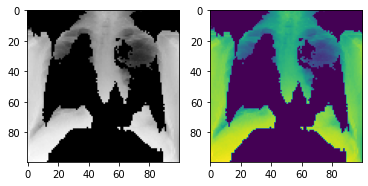

In [35]:
plt.subplot(1, 2, 1)
plt.imshow(img_ej, cmap="gray")
plt.subplot(1, 2, 2)
plt.imshow(img_ej)
plt.show()

En la imagen vemos que utiliza pixeles no relevantes para el diagnóstico (partes blandas del tórax, mediastino), y algunos pixeles que sí son importantes y tenidos en cuenta para el diagnóstico de la enfermedad (bases pulmonares y sectores apicales del pulmón).

In [45]:
imgnue = cv2.imread('../img_prediccion/7.jpg', cv2.COLOR_BGR2GRAY)

In [48]:
imgnue.shape

(2249, 2809, 3)

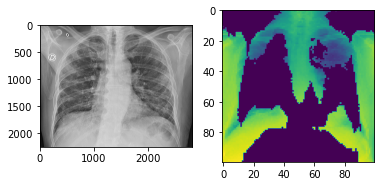

In [51]:
plt.subplot(1, 2, 1)
plt.imshow(imgnue, cmap="gray")
plt.subplot(1, 2, 2)
plt.imshow(img_ej)
plt.show()

In [52]:
imgnue.shape

(2249, 2809, 3)

In [47]:
from lime import lime_image

In [49]:

explainer = lime_image.LimeImageExplainer()

explanation = explainer.explain_instance(
    image=imgnue, 
    classifier_fn=model_logreg.predict_proba, 
    top_labels=1, 
    hide_color=0, 
    num_features=20, 
    num_samples=500)


ValueError: Found array with dim 4. Estimator expected <= 2.

In [ ]:
masked_image, boundaries = explanation.get_image_and_mask(
    label=336, 
    positive_only=True, 
    num_features=6, 
    hide_rest=True)

plt.imshow(mark_boundaries(masked_image / 2 + 0.5, boundaries))
